## I've left the hungarian comments in the code, my own comments and the sollution is in 6th cell between the # HF2 start l2reg and the # HF2 end l2reg comments.

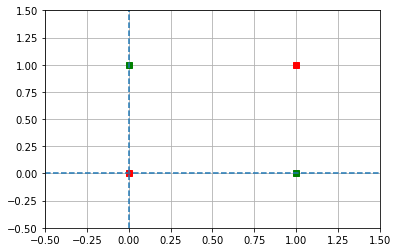

In [1]:
# A notebook alapú megjelenítés aktiválása
%matplotlib inline
import matplotlib.pyplot as plt # Pylab grafikus megjelenítocsomag importálása

# "Igaz" logikai értékek megadása
true_x = [1, 0]
true_y = [0, 1]

# "Hamis" logikai értékek megadása
false_x = [0, 1]
false_y = [0, 1]

# Jelöljük pirossal a hamis logikai értékeket, zölddel pedig az igazakat.
plot1 = plt.plot(true_x, true_y,'gs')
plot2 = plt.plot(false_x, false_y, 'rs')

# A jobb ábrázálhatóság miatt, szélesebb tartományokat jelenítünk meg
plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 1.5)

# Négyzetrács megjelenítése
plt.grid(True)

# Az x és y tengely megjelenítése
plt.axhline(0, linestyle='dashed')
plt.axvline(0, linestyle='dashed')

# Az ábra kirajzolása
plt.show()

In [2]:
import numpy as np
from sklearn import preprocessing
import copy

In [3]:
def activation(x):
    return 1 / (1 + np.exp(-x))

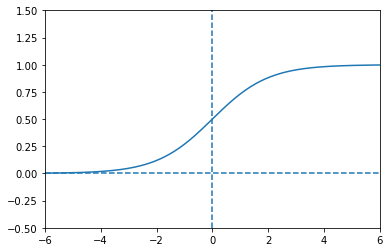

In [4]:
segedX=np.linspace(-6,6,200)
# A jobb ábrázálhatóság miatt, szélesebb tartományokat jelenítünk meg
plt.xlim(-6, 6)
plt.ylim(-0.5, 1.5)
# Az x és y tengely megjelenítése
plt.axhline(0, linestyle='dashed')
plt.axvline(0, linestyle='dashed')
plt.plot(segedX,activation(segedX))

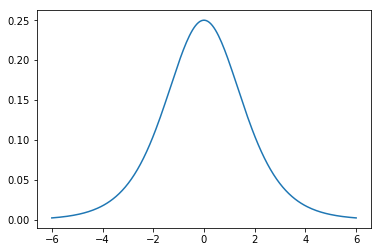

In [5]:
def dactivation(x):
    return np.exp(-x)/((1+np.exp(-x))**2)
plt.plot(segedX,dactivation(segedX))

In [6]:
# MLP osztály létrehozása.
class MLP:
    
    # A hálózat inicializálása az argumentumként megadott méretek alapján.
    def __init__(self, *args):
        # random seed megadása
        np.random.seed(123)
        # A hálózat formája (rétegek száma), amely megegyezik a paraméterek számával
        self.shape = args
        n = len(args)
        # Rétegek létrehozása
        self.layers = []
        # Bemeneti réteg létrehozása (+1 egység a BIAS-nak)
        self.layers.append(np.ones(self.shape[0]+1))
        # Rejtett réteg(ek) és a kimeneti réteg létrehozása
        for i in range(1,n):
            self.layers.append(np.ones(self.shape[i]))
        # Súlymátrix létrehozása
        self.weights = []
        for i in range(n-1):
            self.weights.append(np.zeros((self.layers[i].size,
                                         self.layers[i+1].size)))
        # dw fogja tartalmazni a súlyok utolsó módosításait (később pl. a momentum módszer számára)
        self.dw = [0,]*len(self.weights)
        # Súlyok újrainicializálása
        self.reset()
    
    # Súlyok újrainicializálási függvényének definiálása
    def reset(self):
        for i in range(len(self.weights)):
            # véletlen számok [0,1) tartományban 
            Z = np.random.random((self.layers[i].size,self.layers[i+1].size))
            # átskálázzuk a súlyokat -1..1 tartományba
            self.weights[i][...] = (2*Z-1)*1

    # A bemenő adatok végigküldése a hálózaton, kimeneti rétegig (forward propagation)
    def propagate_forward(self, data):
        # Bemeneti réteg beállítása (tanító adatok)
        self.layers[0][0:-1] = data
        # Az adatok végigküldése a bemeneti rétegtől az utolsó előtti rétegig (az utolsó ugyanis a kimeneti réteg).
        # A szigmoid aktivációs függvény használatával, mátrixszorzások alkalmazásával.
        # Az előadáson a "layers" változót jelöltük "a"-val.
        for i in range(1,len(self.shape)):
            self.layers[i][...] = activation(np.dot(self.layers[i-1],self.weights[i-1]))
        # Visszatérés a hálózat által becsült eredménnyel
        return self.layers[-1]

    # Hibavisszaterjesztés (backpropagation) definiálása. 
    # A a learning rate (tanulási ráta) paraméter befolyásolja, hogy a hálózat súlyait milyen
    # mértékben módosítsuk a gradiens függvényében. Ha ez az érték túl magas, akkor a háló 
    # "oszcillálhat" egy lokális vagy globális minimum körül. Ha túl kicsi értéket választunk,
    # akkor pedig jelentősen több időbe telik mire elérjük a legjobb megoldást vagy leakad egy lokális 
    # minimumban és sose éri el azt.
    
    def propagate_backward(self, target, lrate=0.1):
        deltas = []
        
        
        
        # HF2 start l2reg
        
        # To achive L2 regualrization, we have to sum up all the weights in the network
        # I store the sum of the weights in wsum
        
        wsum = 0
        lambd = 0.1 #lambda, a constant which is necessary for L2 regularization
        
        for w in self.weights:
            for w2 in w:
                for w3 in w2:
                    wsum += w3
        
        
        # Calculates the error in the output layer
        # For the regularization, we have to add 1/2 * lamda * sum(pow(weights, 2)) to our cost function
        error = -(target-self.layers[-1]) + 1/2*lambd*wsum**2
        
        # HF2 end l2reg
        
        
        
        # error*dactivation(s(3))
        delta = np.multiply(error,dactivation(np.dot(self.layers[-2],self.weights[-1])))
        deltas.append(delta)
        # Gradiens kiszámítása a rejtett réteg(ek)ben
        for i in range(len(self.shape)-2,0,-1):
            # pl. utolsó rejtett réteg: delta(3)*(W(2).T)*dactivation(s(2)) (lásd előadás)
            delta=np.dot(deltas[0],self.weights[i].T)*dactivation(np.dot(self.layers[i-1],self.weights[i-1]))
            deltas.insert(0,delta)            
        # Súlyok módosítása
        for i in range(len(self.weights)):
            layer = np.atleast_2d(self.layers[i])
            delta = np.atleast_2d(deltas[i])
            # pl. utolsó rétegben: delta(3)*a(2) (lásd előadás)
            dw = -lrate*np.dot(layer.T,delta)
            
            
            
            # HF2 start l2reg
            # We have to add -learning_rate*lambda*weight(t)
            # to the usual weight refreshing function (weight(t+1) = weight(t) + learning_rate*delta)
            self.weights[i] += dw -lrate*lambd*dw
            # HF2 end l2reg

            
            
            # a súlymódosítás eltárolása
            self.dw[i] = dw

        # Visszatérés a hibával
        return (error**2).sum()

In [7]:
def learn(network, X, Y, valid_split, test_split, epochs=20, lrate=0.1):

        # train-validation-test minták különválasztása
        X_train = X[0:int(nb_samples*(1-valid_split-test_split))]
        Y_train = Y[0:int(nb_samples*(1-valid_split-test_split))]
        X_valid = X[int(nb_samples*(1-valid_split-test_split)):int(nb_samples*(1-test_split))]
        Y_valid = Y[int(nb_samples*(1-valid_split-test_split)):int(nb_samples*(1-test_split))]
        X_test  = X[int(nb_samples*(1-test_split)):]
        Y_test  = Y[int(nb_samples*(1-test_split)):]
    
        # standardizálás
        scaler = preprocessing.StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_valid = scaler.transform(X_valid)
        X_test  = scaler.transform(X_test)
    
        # ugyanolyan sorrendben keverjük be a bemeneteket és kimeneteket, a három külön adatbázisra
        randperm = np.random.permutation(len(X_train))
        X_train, Y_train = X_train[randperm], Y_train[randperm]
        randperm = np.random.permutation(len(X_valid))
        X_valid, Y_valid = X_valid[randperm], Y_valid[randperm]
        randperm = np.random.permutation(len(X_test))
        X_test, Y_test = X_test[randperm], Y_test[randperm]
        
        best_valid_err = np.inf
        es_counter = 0 # early stopping counter
        best_model = network
    
        # Tanítási fázis, epoch-szor megyünk át 1-1 véltelenszerűen kiválasztott mintán.
        for i in range(epochs):
            # Jelen megoldás azt a módszert használja, hogy a megadott 
            # tanító adatokon végigmegyünk és minden elemet először végigküldünk
            # a hálózaton, majd terjeszti vissza a kapott eltérést az
            # elvárt eredménytől. Ezt hívjuk SGD-ek (stochastic gradient descent).
            train_err = 0
            for k in range(X_train.shape[0]):
                network.propagate_forward( X_train[k] )
                train_err += network.propagate_backward( Y_train[k], lrate )
            train_err /= X_train.shape[0]

            # validációs fázis
            valid_err = 0
            o_valid = np.zeros(X_valid.shape[0])
            for k in range(X_valid.shape[0]):
                o_valid[k] = network.propagate_forward(X_valid[k])
                valid_err += (o_valid[k]-Y_valid[k])**2
            valid_err /= X_valid.shape[0]

            print("%d epoch, train_err: %.4f, valid_err: %.4f" % (i, train_err, valid_err))

        # Tesztelési fázis
        print("\n--- TESZTELÉS ---\n")
        test_err = 0
        o_test = np.zeros(X_test.shape[0])
        for k in range(X_test.shape[0]):
            o_test[k] = network.propagate_forward(X_test[k])
            test_err += (o_test[k]-Y_test[k])**2
            print(k, X_test[k], '%.2f' % o_test[k], ' (elvart eredmeny: %.2f)' % Y_test[k])
        test_err /= X_test.shape[0]

        fig1=plt.figure()
        plt.scatter(X_test[:,0], X_test[:,1], c=np.round(o_test[:]), cmap=plt.cm.cool)

In [8]:
# Mesterséges neurális hálózat létrehozása, 2 bemenettel, 10 rejtett neuronnal és 1 kimenettel
network = MLP(2,10,1)

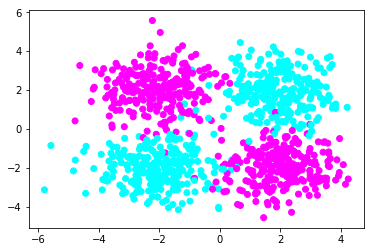

In [9]:
# Tanító, validációs és teszt adatok megadása a rendszernek (zajjal terhelt XOR adatok)
nb_samples=1000
X = np.zeros((nb_samples,2))
Y = np.zeros(nb_samples)
for i in range(0,nb_samples,4):
    noise = np.random.normal(0,1,8)
    X[i], Y[i] = (-2+noise[0],-2+noise[1]), 0
    X[i+1], Y[i+1] = (2+noise[2],-2+noise[3]), 1
    X[i+2], Y[i+2] = (-2+noise[4],2+noise[5]), 1
    X[i+3], Y[i+3] = (2+noise[6],2+noise[7]), 0

# ...és az adatok kirajzolása
fig1=plt.figure()
plt.scatter(X[:,0],X[:,1],c=Y[:], cmap=plt.cm.cool)

0 epoch, train_err: 0.2470, valid_err: 0.2390
1 epoch, train_err: 0.2329, valid_err: 0.2235
2 epoch, train_err: 0.2118, valid_err: 0.1968
3 epoch, train_err: 0.1805, valid_err: 0.1619
4 epoch, train_err: 0.1450, valid_err: 0.1288
5 epoch, train_err: 0.1147, valid_err: 0.1041
6 epoch, train_err: 0.0933, valid_err: 0.0874
7 epoch, train_err: 0.0791, valid_err: 0.0763
8 epoch, train_err: 0.0695, valid_err: 0.0686
9 epoch, train_err: 0.0630, valid_err: 0.0632
10 epoch, train_err: 0.0583, valid_err: 0.0592
11 epoch, train_err: 0.0548, valid_err: 0.0562
12 epoch, train_err: 0.0522, valid_err: 0.0538
13 epoch, train_err: 0.0502, valid_err: 0.0519
14 epoch, train_err: 0.0486, valid_err: 0.0505
15 epoch, train_err: 0.0473, valid_err: 0.0492
16 epoch, train_err: 0.0462, valid_err: 0.0482
17 epoch, train_err: 0.0453, valid_err: 0.0474
18 epoch, train_err: 0.0446, valid_err: 0.0467
19 epoch, train_err: 0.0440, valid_err: 0.0461

--- TESZTELÉS ---

0 [-0.6956089  -1.37664792] 0.05  (elvart eredmeny

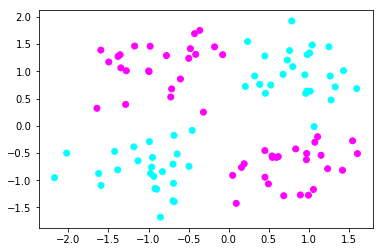

In [10]:
# Tanítás/Tesztelés indítása
network.reset()
learn(network, X, Y, 0.2, 0.1)